# Demo: Peptide Prediction with BigQuery ML/ Auto ML. Model Virus Mutation

### Supporting research: Covid19 and beyond for vaccine candidates 

BigQuery ML enables users to create and execute machine learning models in BigQuery using SQL queries. The goal is to democratize machine learning by enabling SQL practitioners to build models using their existing tools and to increase development speed by eliminating the need for data movement.
In this tutorial, you use the sample Covid19 dataset for BigQuery.
Comments & Feedback @jigmehta
## Objectives
In this tutorial, you will use BigQuery to explore immunological data, AutoML to automatically generate ML model for peptide binding. Also, you will leverage BQML to explore vareous ML models and perform feature engineering:
+ BigQuery `ML.CREATE` to create a classification model using the `CREATE MODEL` statement
+ The `ML.EVALUATE` function to evaluate the ML model
+ Use `ML.TRANSFORM`feature engineering functions to improve model performance
+ The `ML.PREDICT` function to make predictions using the ML model

Jupyter magics are notebook-specific shortcuts that allow you to run commands with minimal syntax. Jupyter notebooks come with many [built-in commands](https://ipython.readthedocs.io/en/stable/interactive/magics.html). The BigQuery client library, `google-cloud-bigquery`, provides a cell magic, `%%bigquery`. The `%%bigquery` magic runs a SQL query and returns the results as a pandas `DataFrame`.

## Step 1: Explore Peptidic Epitope Data
For our coronavirus subset of data, let's examine data first:
+ Following query shows information about antigen.
+ Observe specific antigen that might of more interest to our study for coronavirus.
+ Can you find it?


In [2]:
# Read GCP project id from env.
shell_output=!gcloud config list --format 'value(core.project)' 2>/dev/null
GCP_PROJECT_ID=shell_output[0]
print("GCP project ID:" + GCP_PROJECT_ID)

GCP project ID:covid-19-271622


In [3]:
# Define project__id variable
project_id = 'covid-19-271622'

In [4]:
%%bigquery --project $project_id
SELECT * 
FROM `corona.antigen`
LIMIT 10

,Antigen_Name,Organism_Name,__Epitopes,__Assays,__References
0,Nucleoprotein,Avian coronavirus,1,2,1
1,Other Avian coronavirus protein,Avian coronavirus,1,1,1
2,Replicase polyprotein 1ab,Betacoronavirus 1,1,1,1
3,Non-structural protein 2a,Betacoronavirus 1,1,5,1
4,Replicase polyprotein 1ab,Alphacoronavirus 1,1,1,1
5,Nucleoprotein,Alphacoronavirus 1,1,1,1
6,Envelope small membrane protein,Murine coronavirus,16,32,1
7,Membrane protein,Murine coronavirus,44,91,1
8,Spike glycoprotein,Human coronavirus 229E,3,6,1
9,nucleoprotein,Middle East respiratory syndrome-related coron...,94,94,1


Visually inspect number of epitopes by antigen name in our dataset.

In [5]:
%%bigquery epitopes --project $project_id
SELECT
 Antigen_Name,
 sum(__Epitopes) AS epitope
FROM `corona.antigen`
GROUP BY Antigen_Name
ORDER BY epitope DESC

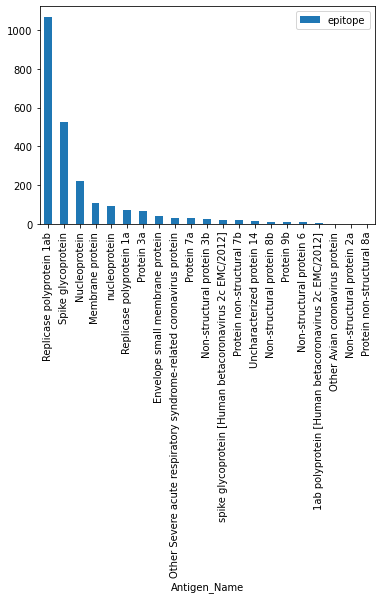

In [6]:
epitopes.plot(kind='bar', x='Antigen_Name', y='epitope');

In [7]:
# Following query shows epitope detail for those linear peptides whose parent protein
# came from Spike glycoprotein, which is our interests to investigate for possible antigen
# to protect against coronavirus


In [8]:
%%bigquery --project $project_id
SELECT Epitope_ID, Object_Type, Description, Starting_Position,
            Ending_Position, Antigen_Name,Parent_Protein, Organism_Name
FROM `corona.epitope` 
WHERE Parent_Protein = 'Spike glycoprotein'
LIMIT 10

,Epitope_ID,Object_Type,Description,Starting_Position,Ending_Position,Antigen_Name,Parent_Protein,Organism_Name
0,2801,Linear peptide,ALNTLVKQL,940,948,Spike glycoprotein precursor,Spike glycoprotein,SARS coronavirus BJ01
1,12967,Linear peptide,ELCDNPFFA,131,139,Spike glycoprotein precursor,Spike glycoprotein,SARS coronavirus BJ01
2,26710,Linear peptide,IITTDNTFV,1096,1104,Spike glycoprotein precursor,Spike glycoprotein,SARS coronavirus BJ01
3,27146,Linear peptide,ILLCCMTSC,1214,1222,Spike glycoprotein precursor,Spike glycoprotein,SARS coronavirus BJ01
4,27241,Linear peptide,ILPDPLKPT,787,795,Spike glycoprotein precursor,Spike glycoprotein,SARS coronavirus BJ01
5,32036,Linear peptide,KLNDLCFSNV,373,382,Spike glycoprotein precursor,Spike glycoprotein,SARS coronavirus BJ01
6,32068,Linear peptide,KLPDDFMGC,411,419,Spike glycoprotein precursor,Spike glycoprotein,SARS coronavirus BJ01
7,32069,Linear peptide,KLPDDFMGCV,411,420,Spike glycoprotein precursor,Spike glycoprotein,SARS coronavirus BJ01
8,36724,Linear peptide,LITGRLQSL,978,986,Spike glycoprotein precursor,Spike glycoprotein,SARS coronavirus BJ01
9,37544,Linear peptide,LLLQYGSFC,734,742,Spike glycoprotein precursor,Spike glycoprotein,SARS coronavirus BJ01


As you can see from the resulting query, we have a set of peptides generated from parent antigen protein. Now, we need to identify how these peptides bind with HLA molecule.

Following query shows HLA-peptide binding affinity information. The goal is to leverage machine learning models to predict binding affinity for many different and new peptides with HLA MHC Class-I molecules so that testing for vaccine candidates can be prioritized to accelerate solutions.


In [9]:
%%bigquery --project $project_id
SELECT Reference_ID, Description, Allele_Name,MHC_allele_class, Assay_Group,
       Qualitative_Measure, Quantitative_measurement 
FROM `corona.mhc_ligand`
WHERE Epitope_ID = 12967 


,Reference_ID,Description,Allele_Name,MHC_allele_class,Assay_Group,Qualitative_Measure,Quantitative_measurement
0,642,ELCDNPFFA,HLA-A*02:01,I,qualitative binding,Positive,0.4


In our dataset there are multiple of alleles and, for each allele we have epitope binding affinity measure. Lete inspect how epitopes and allele bindings are distributed in the dataset. This is one way to short list possible allele to consider for peptide binding research.

We will use dataframe to hold query result to build our visualization.

In [10]:
from google.cloud import bigquery
client = bigquery.Client()

In [11]:
sql = """
SELECT Qualitative_Measure, 
       Allele_Name, 
       count(1) as count 
FROM `corona.mhc_ligand`
GROUP BY  1,2
ORDER BY 3 DESC
"""
df = client.query(sql).to_dataframe()
df.head()

,Qualitative_Measure,Allele_Name,count
0,Negative,HLA-A*01:01,443
1,Negative,HLA-A*24:02,438
2,Positive-High,HLA-A*02:01,406
3,Negative,HLA-A*26:01,393
4,Positive-High,HLA-A*02:02,392


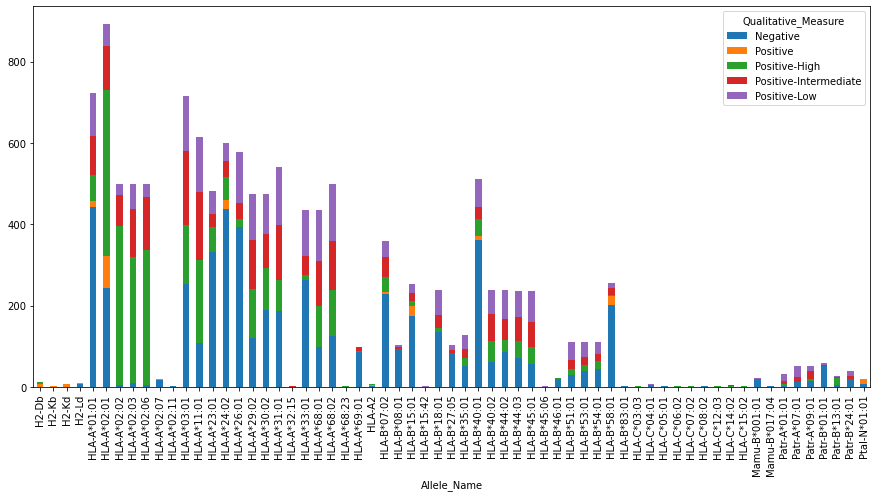

In [12]:
pivot_table = df.pivot(index='Allele_Name', columns='Qualitative_Measure', values='count')
pivot_table.plot(kind='bar', stacked=True, figsize=(15, 7));

Based on data insepction, it seems like for coronavirus data set, HLA-A-01-01, HLA-A-02-01, HLA-A-02-02, HLA-A-02-03 and HLA-A-020-06 alleles are most likely candidates for MHC-I molecules.

It is important to narrow down focus peptides and HLA binding to speed up testing on most probable vaccine candidate. Lets identify set of peptides that binds well with HLA, you can further narrow it to specific HLA as well. Following qury execution suggest that peptides with length of 9 and 10 are having better binding affinity. We should focus our research on those for now. Of course, more factors, features as well as 3D structure of aplha/beta components of HLA+Peptide bindings are useful for more complex modeling. 

In [13]:
sql = """
SELECT Qualitative_Measure, 
       length(Description) as Peptide_Length, 
       count(1) as count 
FROM `corona.mhc_ligand`
GROUP BY  1,2
ORDER BY 3 DESC
"""
df = client.query(sql).to_dataframe()
df.head()

,Qualitative_Measure,Peptide_Length,count
0,Negative,9,3974
1,Positive-High,9,2008
2,Positive-Low,9,1275
3,Positive-Intermediate,9,1260
4,Negative,10,1196


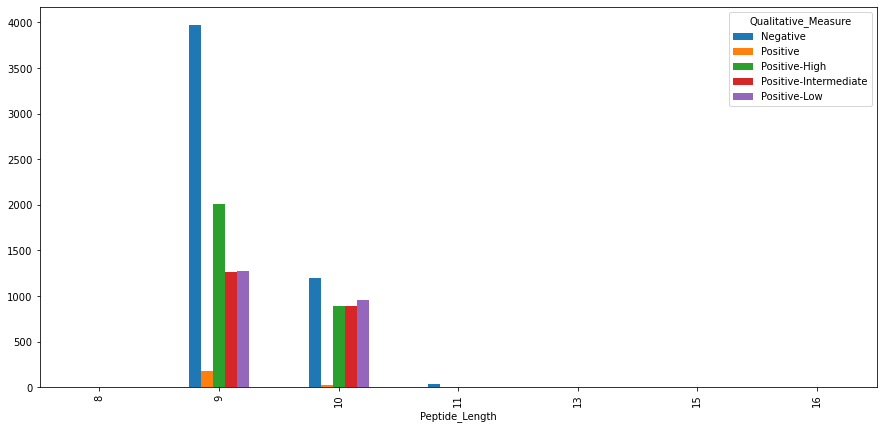

In [14]:
pivot_table = df.pivot(index='Peptide_Length', columns='Qualitative_Measure', values='count')
pivot_table.plot(kind='bar', stacked=False, figsize=(15, 7));

Lets build feature table that translate Peotide Amino Acid sqquence into positioning columns. Explore amino acid properties table, it is prepared with allocation of acid sequnece number as well as additional properites that you can leverage for cross feature engineering.

In [15]:
%%bigquery --project $project_id
SELECT *
FROM `hla_peptide_generic.amino_acid`

,a_index,amino_acid,abbriviation,short_abrv,formula,polarity,hydropathy_index,molecular_weight,isoelectric_point
0,21,Any amino acid,Xaa,X,None,None,0.00,0.00,0.00
1,1,Alanine,Ala,A,C3H7N1O2,Uncharged,0.62,89.09,6.00
2,8,Glycine,Gly,G,C2H5N1O2,Uncharged,0.48,75.07,5.97
3,10,Isoleucine,Ile,I,C6H13N1O2,Uncharged,1.40,131.17,5.94
4,11,Leucine,Leu,L,C6H13N1O2,Uncharged,1.10,131.17,5.98
5,14,Phenylalanine,Phe,F,C9H11N1O2,Uncharged,1.20,165.19,5.48
6,15,Proline,Pro,P,C5H9N1O2,Uncharged,0.12,115.13,6.30
7,20,Valine,Val,V,C5H11N1O2,Uncharged,1.10,117.15,5.96
8,3,Asparagine,Asn,N,C4H8N2O3,Non-Polarity,-0.78,132.12,5.41
9,5,Cysteine,Cys,C,C3H7N1O2S1,Non-Polarity,0.29,121.16,5.02


We will examine pre-built feature table called mhc_qual_feature which has column presentation of 9 and 10 letter (MER) peptide sequence which are most suitable for MHC-1 binding. Table also contains qualitative measure and quantitative measure.

+ Peptides are transformed into column A1 to A10 based on amino acid position value in a chain
+ result_score is quantitative measure: lower the number, higher binding affinity
+ result columns is binary classification based on 5 class result_quality score

In [98]:
%%bigquery --project $project_id
SELECT *
FROM `corona.mhc_qual_feature`
LIMIT 10

,ligand_id,peptide,result_type,result,Allele,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,result_score,result_quality
0,1717014,ILLNKHID,Positive-Low,0,HLA-A*02:01,0,0,0,0,0,0,0,0,0,0,4000.0,1
1,1025027,AACAMLLVK,Negative,0,HLA-A*68:01,1,1,5,1,13,11,11,20,12,0,16800.0,0
2,1025025,AACAMLLVK,Negative,0,HLA-A*31:01,1,1,5,1,13,11,11,20,12,0,10600.0,0
3,1025026,AACAMLLVK,Negative,0,HLA-A*33:01,1,1,5,1,13,11,11,20,12,0,77700.0,0
4,1025023,AACAMLLVK,Positive-Low,0,HLA-A*03:01,1,1,5,1,13,11,11,20,12,0,638.0,1
5,1025197,AAISDYDYY,Positive-Low,0,HLA-A*68:01,1,1,10,16,4,19,4,19,19,0,4810.0,1
6,1025194,AAISDYDYY,Positive-Low,0,HLA-A*11:01,1,1,10,16,4,19,4,19,19,0,1100.0,1
7,1025195,AAISDYDYY,Negative,0,HLA-A*31:01,1,1,10,16,4,19,4,19,19,0,17500.0,0
8,1025193,AAISDYDYY,Positive-Low,0,HLA-A*03:01,1,1,10,16,4,19,4,19,19,0,698.0,1
9,1025196,AAISDYDYY,Negative,0,HLA-A*33:01,1,1,10,16,4,19,4,19,19,0,77700.0,0


## Step 2: Build  Classification Model with AutoML and Built-in algorith training
Building ML models with AutoML is as simple as writing SQL statements; makes ML modeling accessible to even SQL developers and analysts. We will create a simple classification model to predict for a given peptide if there is strong binding affinity with certain HLA Allele.

AutoML perform feature engineering, model selection and hyperparameter tuning. We are just selecting feature columns of Allele and amino acid positioning within a peptide to classify if a peptide is a good candidate for vaccine testing.

+ Note: we are filtering data for peptides with length of 9 or 10 mers only. 

Visit AutoML Tables in the Google Cloud Console to begin the process of creating your dataset and training your model.
+ Go to the AutoML Tables page (https://cloud.google.com/automl-tables/docs/quickstart)
+ Select Datasets, and then select New dataset.
+ Enter Quickstart_Dataset for the dataset name and click Create dataset.
+ On the Import your data page, choose Select Import Data from BigQuery.
+ Provide BigQuery project ID (covid-19-271622), Data Set (corona) and Table (mhc_qual_feature)
+ Click Import.
+.....
+ 

## Step 3: Build You First Classification Model with BQML
Building ML models with BigQuery is as simple as writing SQL statements; makes ML modeling accessible to even SQL developers and analysts. We will create a simple classification model to predict for a given peptide if there is strong binding affinity with certain HLA Allele.

Following statement creates a classification model using logistic regression. We are selecting feature columns of Allele and amino acid positioning within a peptide to classify if a peptide is a good candidate for vaccine testing.

+ Note: we are filtering data for peptides with length of 9 or 10 mers only. Also, since we run multiple samples, we are randomizing samples by 80% of data for learning.


In [99]:
%%bigquery --project $project_id
CREATE OR REPLACE MODEL `corona.Classification_model_bq1`
OPTIONS
(
model_type='logistic_reg',
input_label_cols=['result_quality']
)
AS
SELECT
 result_quality, Allele, A1, A2, A3, A4, A5, A6, A7, A8, A9, A10
 FROM
  `corona.mhc_qual_feature`
 WHERE length(peptide) IN (9,10)
 AND rand() < 0.8

""


The query takes several minutes to complete. After the first iteration is
complete, your model (`Classification_model_bq1`) appears in the navigation panel of the
BigQuery web UI. Because the query uses a `CREATE MODEL` statement to create a
table, you do not see query results. The output is an empty `DataFrame`.

## Get training statistics

To see the results of the model training, you can use the
[`ML.TRAINING_INFO`](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-train)
function, or you can view the statistics in the BigQuery web UI.
In this tutorial, you use the `ML.TRAINING_INFO` function.

A machine learning algorithm builds a model by examining many examples and
attempting to find a model that minimizes loss. This process is called empirical
risk minimization.

Loss is the penalty for a bad prediction &mdash; a number indicating
how bad the model's prediction was on a single example. If the model's
prediction is perfect, the loss is zero; otherwise, the loss is greater. The
goal of training a model is to find a set of weights that have low
loss, on average, across all examples.

To see the model training statistics that were generated when you ran the
`CREATE MODEL` query:

In [100]:
%%bigquery --project $project_id
SELECT
  *
FROM
  ML.TRAINING_INFO(MODEL `corona.Classification_model_bq1`)

,training_run,iteration,loss,eval_loss,learning_rate,duration_ms
0,0,6,0.225106,0.231255,3.2,3884
1,0,5,0.226000,0.232633,6.4,5202
2,0,4,0.230595,0.235807,3.2,3938
3,0,3,0.241606,0.244936,1.6,4254
4,0,2,0.264432,0.266417,0.8,4552
5,0,1,0.290915,0.291899,0.4,4521
6,0,0,0.310346,0.310697,0.2,2939


In [101]:
%%bigquery loss_curve --project $project_id
SELECT
  iteration, loss, eval_loss
FROM
  ML.TRAINING_INFO(MODEL `corona.Classification_model_bq1`)
ORDER BY iteration ASC

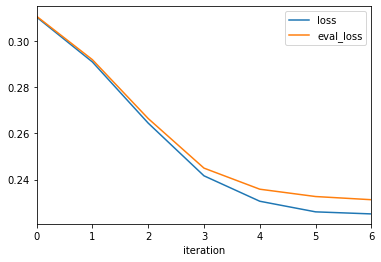

In [102]:
loss_curve.plot(x='iteration');

The `loss` column represents the loss metric calculated after the given iteration
on the training dataset. Since you performed a logistic regression, this column
is the [log loss](https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_error_function_and_logistic_regression).
The `eval_loss` column is the same loss metric calculated on
the holdout dataset (data that is held back from training to validate the model).

For more details on the `ML.TRAINING_INFO` function, see the
[BigQuery ML syntax reference](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-train).

## Evaluate your model

After creating your model, you evaluate the performance of the classifier using
the [`ML.EVALUATE`](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-evaluate)
function. You can also use the [`ML.ROC_CURVE`](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-roc)
function for logistic regression specific metrics.

A classifier is one of a set of enumerated target values for a label. For
example, in this tutorial you are using a binary classification model that
detects transactions. The two classes are the values in the `label` column:
`0` (no transactions) and not `1` (transaction made).

To run the `ML.EVALUATE` query that evaluates the model:

In [103]:
%%bigquery --project $project_id
SELECT
  *
FROM ML.EVALUATE(MODEL `corona.Classification_model_bq1`)

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.520667,0.338201,0.516683,0.327543,1.60369,0.766784


In [104]:
%%bigquery --project $project_id
SELECT roc_auc,
       CASE WHEN roc_auc > .85 THEN 'good'
            WHEN roc_auc > .7 THEN 'fair'
            WHEN roc_auc > .5 THEN 'not great'
            ELSE 'poor' END AS model_quality
FROM ML.EVALUATE(MODEL `corona.Classification_model_bq1`)

,roc_auc,model_quality
0,0.766784,fair


## Step 4: Improve Model Performance with Feature Engineering
BigQuery offers many [transform / preprocessing](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-preprocessing-functions) functions for feature engineering on data. Advantage of transform functions is that once you build a model with preprocessing as part of model definition, prediction data does not need to be prepared as the model will apply transformation for the input. Lets see one example of a transform feature and rebuild our model to check if we get better model performance.

Following statement will create another classification model with preprocessing of the result score to normalize its deviation with respect to min-max value of an attribute.


In [105]:
%%bigquery --project $project_id
CREATE OR REPLACE MODEL `corona.Classification_model_bq2`
TRANSFORM (result_quality, Allele, A1, A2, A3, A4, A5, A6, A7, A8, A9, A10, 
           ML.MIN_MAX_SCALER(result_score) OVER() AS rs
)
OPTIONS
(
model_type='logistic_reg',
input_label_cols=['result_quality']
)
AS
SELECT result_quality, Allele, A1, A2, A3, A4, A5, A6, A7, A8, A9, A10, result_score
FROM `corona.mhc_qual_feature`
WHERE length(peptide) IN (9,10)
AND rand() < 0.8

""


The query takes several minutes to complete. After the first iteration is
complete, your model (`Classification_model_bq2`) appears in the navigation panel of the
BigQuery web UI. The output is an empty `DataFrame`.

Check model performance after feature engineering, run the `ML.EVALUATE` query that evaluates the model:

In [106]:
%%bigquery loss_curve2 --project $project_id
SELECT
  iteration, loss, eval_loss
FROM
  ML.TRAINING_INFO(MODEL `corona.Classification_model_bq2`)
ORDER BY iteration ASC

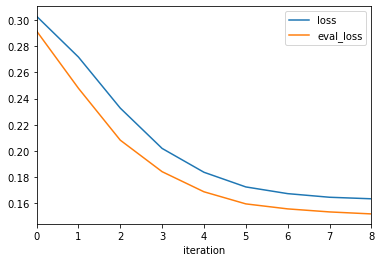

In [107]:
loss_curve2.plot(x='iteration');

In [96]:
%%bigquery --project $project_id
SELECT roc_auc,
       CASE WHEN roc_auc > .85 THEN 'good'
            WHEN roc_auc > .7 THEN 'fair'
            WHEN roc_auc > .5 THEN 'not great'
            ELSE 'poor' END AS model_quality
FROM ML.EVALUATE(MODEL `corona.Classification_model_bq2`)

,roc_auc,model_quality
0,0.882205,good


As you can see model performance has improved!

With BigQuery you can take advantage of an already available highly powerful computer data processing and analysis platform to build a machine learning model, without moving your data! You can learn more about BQML here. For our data set, you can build a DNN_Regression model to predict the result_score for a peptide HLA binding. Try that as a practice!

## Step 5: Run Prediction on BQML Model
Now that you have evaluated your model, the next step is to use it to predict
outcomes. 

To run the query that uses the model to predict the number of transactions:
Following example demonstrate leveraging BQ model for prediction. Optionally, you can export model and publish it on to Google AI Platform for serving prediction.


In [108]:
%%bigquery --project $project_id
SELECT
  predicted_result_quality, predicted_result_quality_probs, result_quality as original_result, result_score
FROM ML.PREDICT(MODEL `corona.Classification_model_bq2`, (
  SELECT result_quality, Allele, A1, A2, A3, A4, A5, A6, A7, A8, A9, A10, result_score
  FROM `corona.mhc_qual_feature`
  WHERE length(peptide) IN (9,10)
  AND rand() < 0.0009))

,predicted_result_quality,predicted_result_quality_probs,original_result,result_score
0,0,"[{'label': 0, 'prob': 0.9936144913741106}, {'l...",0,100000.0
1,1,"[{'label': 1, 'prob': 0.4481498093231377}, {'l...",1,666.0
2,2,"[{'label': 2, 'prob': 0.33344207995146574}, {'...",1,1110.0
3,0,"[{'label': 0, 'prob': 0.2857207926350532}, {'l...",0,9450.0
4,3,"[{'label': 3, 'prob': 0.5592087942243242}, {'l...",3,0.4
5,3,"[{'label': 3, 'prob': 0.5797131590737277}, {'l...",3,1.2
6,1,"[{'label': 1, 'prob': 0.30676182720502726}, {'...",3,11.4
7,2,"[{'label': 2, 'prob': 0.3441210301482357}, {'l...",3,10.3
8,2,"[{'label': 2, 'prob': 0.3602870853690464}, {'l...",3,22.9


The result shows predicted quality class with confidence. You can compare that with original result. Next step is to operationalize ML pipeline so that you can efficiently perform data updates and model updates. Check out AI Pipeline example for peptide prediction to learn more!

# AutoML to explore classification model
Now as we explored Classification model, we might be interested to explore what other models can we used to make better prediction. 
GCP provide a service AutoML 
which allow scientist to submit their data and 
to explore vareous ML models.
+ [AutoML models](https://pantheon.corp.google.com/automl-tables/locations/us-central1/datasets/TBL8658818995480166400;modelId=TBL2508683113329065984;task=basic/schemav2?project=covid-19-271622) can be explored through GCP console
+ You can also call [AutoML from BQML](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create-automl)


In [14]:
# Read GCP project id from env.
shell_output=!gcloud config list --format 'value(core.project)' 2>/dev/null
GCP_PROJECT_ID=shell_output[0]
print("GCP project ID:" + GCP_PROJECT_ID)

GCP project ID:covid-19-271622


## It will take an hour (pre-computed for DEMO)

In [ ]:
%%bigquery --project $GCP_PROJECT_ID
CREATE OR REPLACE MODEL `corona.Classification_model_automl`
OPTIONS
(
model_type='automl_classifier',
input_label_cols=['Qualitative_Measure'],
budget_hours=1.0
)
AS
SELECT
 Qualitative_Measure, Description, Allele_Name, Quantitative_measurement
 FROM
  `bigquery-public-data.immune_epitope_db.mhc_ligand_full`
 WHERE length(Description) IN (9,10)
 AND organism_name like '%coronavirus%'
 AND rand() < 0.8

Executing query with job ID: 4057efd7-b3ec-4a77-815e-976da0d64c77
Query executing: 3181.90s

# You can check vareous models explored by AutoML 
+ AutoML keep [log](https://pantheon.corp.google.com/automl-tables/locations/us-central1/datasets/TBL8658818995480166400;modelId=TBL2508683113329065984;task=basic/train?project=covid-19-271622) of all model configurations it explored
+ [Models](https://pantheon.corp.google.com/logs/query;query=resource.type%3D%22cloudml_job%22%20resource.labels.job_id%3D%22TBL2508683113329065984%22%20resource.labels.project_id%3D%22covid-19-271622%22%20labels.log_type%3D%22automl_tables%22%20jsonPayload.%22@type%22%3D%22type.googleapis.com%2Fgoogle.cloud.automl.master.TablesModelStructure%22?project=covid-19-271622)
+ [Trials](https://pantheon.corp.google.com/logs/query;query=resource.type%3D%22cloudml_job%22%20resource.labels.job_id%3D%22TBL2508683113329065984%22%20resource.labels.project_id%3D%22covid-19-271622%22%20labels.log_type%3D%22automl_tables%22%20jsonPayload.%22@type%22%3D%22type.googleapis.com%2Fgoogle.cloud.automl.master.TuningTrial%22?project=covid-19-271622)

# [Train ML Model at scale](https://pantheon.corp.google.com/ai-platform/pipelines/clusters?project=covid-19-271622)
Now that you have evaluated your first model, the next step is to explore different models at scale.

Following Notebook (AIHub/PublicBQ/Demos/AI_Pipeline_MHC_Peptide.ipynb) demonstrate leveraging AI pipelines to explore vareous algorithms. Optionally, you can export model (AIHub/mch_pipeline/model.py) and publish it on to Google AI Platform for serving prediction.


# Virus Mutation
 
We will explore how model perform when virus mutate. 
+ We can leverage [Google Dataproc](https://pantheon.corp.google.com/dataproc/notebooks/instances?project=covid-19-271622) to explore maltiple mutation scenarious in parallel
+ First we will have to install software: java, ant and [santa-sim](https://github.com/santa-dev/santa-sim) software to perform [virus mutation simulations](https://5t7n4xhkjfgevepr3gf6adhxoq-dot-us-central1.dataproc.googleusercontent.com/jupyter/lab?authuser=0)
 

In [33]:
!gunzip jdk-14.0.1_linux-x64_bin.tar.gz

In [ ]:
!tar -xvf jdk-14.0.1_linux-x64_bin.tar

In [37]:
# Set `PATH` to include java binary directory  
PATH=%env PATH
%env PATH={PATH}:/home/jupyter/AIHub/jdk-14.0.1/bin

env: PATH=/usr/local/cuda/bin:/opt/conda/bin:/opt/conda/condabin:/usr/local/bin:/usr/bin:/bin:/usr/local/games:/usr/games:/home/jupyter/AIHub/jdk-14.0.1/bin


In [39]:
!java -version

java version "14.0.1" 2020-04-14
Java(TM) SE Runtime Environment (build 14.0.1+7)
Java HotSpot(TM) 64-Bit Server VM (build 14.0.1+7, mixed mode, sharing)


In [ ]:
!sudo tar -xzvf apache-ant-1.9.15-bin.tar.gz

In [47]:
# Set `PATH` to include java and ant binary directory  
PATH=%env PATH
%env ANT_HOME=/home/jupyter/AIHub/apache-ant-1.9.15/
%env JAVA_HOME=/home/jupyter/AIHub/jdk-14.0.1/
%env PATH={PATH}:/home/jupyter/AIHub/jdk-14.0.1/bin:/home/jupyter/AIHub/apache-ant-1.9.15/bin

env: ANT_HOME=/home/jupyter/AIHub/apache-ant-1.9.15/
env: JAVA_HOME=/home/jupyter/AIHub/jdk-14.0.1/
env: PATH=/usr/local/cuda/bin:/opt/conda/bin:/opt/conda/condabin:/usr/local/bin:/usr/bin:/bin:/usr/local/games:/usr/games:/home/jupyter/AIHub/jdk-14.0.1/bin:/home/jupyter/AIHub/jdk-14.0.1/bin:/home/jupyter/AIHib/apache-ant-1.9.15/bin:/home/jupyter/AIHub/jdk-14.0.1/bin:/home/jupyter/AIHubb/apache-ant-1.9.15/bin:/home/jupyter/AIHub/jdk-14.0.1/bin:/home/jupyter/AIHub/apache-ant-1.9.15/bin


In [ ]:
!unzip santa-sim-master.zip

In [43]:
cd santa-sim-master

/home/jupyter/AIHub/santa-sim-master


In [49]:
!ant

Buildfile: /home/jupyter/AIHub/santa-sim-master/build.xml

install-ivy:

resolve:
[ivy:retrieve] :: Apache Ivy 2.4.0 - 20141213170938 :: http://ant.apache.org/ivy/ ::
[ivy:retrieve] :: loading settings :: url = jar:file:/home/jupyter/.ant/lib/ivy.jar!/org/apache/ivy/core/settings/ivysettings.xml

init:
    [mkdir] Created dir: /home/jupyter/AIHub/santa-sim-master/build
    [mkdir] Created dir: /home/jupyter/AIHub/santa-sim-master/dist

compile:
    [javac] Compiling 81 source files to /home/jupyter/AIHub/santa-sim-master/build
    [javac] warning: [options] bootstrap class path not set in conjunction with -source 8
    [javac] /home/jupyter/AIHub/santa-sim-master/src/santa/simulator/genomes/Mutations.java:117: warning: [deprecation] Integer(int) in Integer has been deprecated
    [javac]             positions[i] = new Integer(i);
    [javac]                            ^
    [javac] /home/jupyter/AIHub/santa-sim-master/src/santa/simulator/genomes/Mutations.java:122: warning: [deprecatio

## Run simulation to explore mutations

In [23]:
# Set `PATH` to include java and ant binary directory  
PATH=%env PATH
%env ANT_HOME=/home/jupyter/AIHub/apache-ant-1.9.15/
%env JAVA_HOME=/home/jupyter/AIHub/jdk-14.0.1/
%env PATH={PATH}:/home/jupyter/AIHub/jdk-14.0.1/bin:/home/jupyter/AIHub/apache-ant-1.9.15/bin

env: ANT_HOME=/home/jupyter/AIHub/apache-ant-1.9.15/
env: JAVA_HOME=/home/jupyter/AIHub/jdk-14.0.1/
env: PATH=/usr/local/cuda/bin:/opt/conda/bin:/opt/conda/condabin:/usr/local/bin:/usr/bin:/bin:/usr/local/games:/usr/games:/home/jupyter/AIHub/jdk-14.0.1/bin:/home/jupyter/AIHub/apache-ant-1.9.15/bin:/home/jupyter/AIHub/jdk-14.0.1/bin:/home/jupyter/AIHub/apache-ant-1.9.15/bin


In [26]:
pwd

'/home/jupyter/AIHub/PublicBQ/Demos'

In [27]:
cd ../../santa-sim-master

/home/jupyter/AIHub/santa-sim-master


In [28]:
!java -jar /home/jupyter/AIHub/santa-sim-master/dist/santa.jar  examples/covid.xml

Seed: 1596006391331
Jul 29, 2020 7:06:31 AM santa.simulator.Simulator run
INFO: Replicate 1
Jul 29, 2020 7:06:31 AM santa.simulator.Simulator run
INFO: Replicate 1
Starting epoch: (unnamed)
Initial population:  fitness = 1.0, distance = 0.0, max freq = 10000, genepool size = 1 (0 available)
Generation 100:  fitness = 1.0, distance = 35.9001, max freq = 12, genepool size = 7319 (3299 available)
Generation 200:  fitness = 1.0, distance = 71.7807, max freq = 10, genepool size = 7276 (3342 available)
Generation 300:  fitness = 1.0, distance = 107.7143, max freq = 11, genepool size = 7265 (3353 available)
Generation 400:  fitness = 1.0, distance = 143.2131, max freq = 10, genepool size = 7272 (3365 available)
Generation 500:  fitness = 1.0, distance = 179.3326, max freq = 8, genepool size = 7359 (3288 available)
Generation 600:  fitness = 1.0, distance = 215.22, max freq = 10, genepool size = 7250 (3397 available)
Generation 700:  fitness = 1.0, distance = 250.3581, max freq = 9, genepool s

## Translation
+ Copy neurtal.xml to new covid.xml and add COVID-19 sequence to xml
+ https://github.com/geohot/corona
+ https://github.com/nextstrain/ncov
+ https://github.com/galaxyproject/SARS-CoV-2
    
Now we will leverage open source library to perform mutated RNA translation and we will 
explore areas responcible for vareous proteins which might be our targets

## Explore proteins

In [55]:
!python ../COVID19/corona/corona-mutate-np.py

Nucleocapsid Phosphoprotein--> MSDNGPQNQRNAPRITFGGPSDSTGSNQNGERSGARSKQRRPQGLPNNTASWFTALTQHGKEDLKFPRGQGVPINTNSSPDDQIGYYRRATRRIRGGDGKMKDLSPRWYFYYLGTGPEAGLPYGANKDGIIWVATEGALNTPKDHIGTRNPANNAAIVLQLPQGTTLPKGFYAEGSRGGSQASSRSSSRSRNSSRNSTPGSSRGTSPARMAGNGGDAALALLLLDRLNQLESKMSGKGQQQQGQTVTKKSAAEASKKPRQKRTATKAYNVTQAFGRRGPEQTQGNFGDQELIRQGTDYKHWPQIAQFAPSASAFFGMSRIGMEVTPSGTWLTYTGAIKLDDKDPNFKDQVILLNKHIDAYKTFPPTEPKKDKKKKADETQALPQRQKKQQTVTLLPAADLDDFSKQLQQSMSSADSTQA


In [56]:
!python ../COVID19/corona/corona-mutate-mg.py

Membrane Glycoprotein--> MADSNGTITVEELKKLLEQWNLVIGFLFLTWICLLQFAYANRNRFLYIIKLIFLWLLWPVTLACFVLAAVYRINWITGGIAIAMACLVGLMWLSYFIASFRLFARTRSMWSFNPETNILLNVPLHGTILTRPLLESELVIGAVILRGHLRIAGHHLGRCDIKDLPKEITVATSRTLSYYKLGASQRVAGDSGFAAYSRYRIGNYKLNTDHSSSSDNIALLVQ


In [57]:
!python ../COVID19/corona/corona-mutate-ep.py

Envelope Protein also known as small membrane--> MYSFVSEETGTLIVNSVLLFLAFVVFLLVTLAILTALRLCAYCCNIVNVSLVKPSFYVYSRVKNLNSSRVPDLLV


In [58]:
!python ../COVID19/corona/corona-mutate-spike.py

Spike Glycoprotein--> MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPRRARSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLN

# Generate new peptide candidates

In [67]:
!python ../COVID19/corona/corona-mutate-peptides.py

+++++++++++++++++++++++++++++++++++++
                                     
+++++++++++++++++++++++++++++++++++++
Spike Glycoprotein peptides MFVFLVLL
Spike Glycoprotein peptides FVFLVLLP
Spike Glycoprotein peptides VFLVLLPL
Spike Glycoprotein peptides FLVLLPLV
Spike Glycoprotein peptides LVLLPLVS
Spike Glycoprotein peptides VLLPLVSS
Spike Glycoprotein peptides LLPLVSSQ
Spike Glycoprotein peptides LPLVSSQC
Spike Glycoprotein peptides PLVSSQCV
Spike Glycoprotein peptides LVSSQCVN
........
+++++++++++++++++++++++++++++++++++++
                                     
+++++++++++++++++++++++++++++++++++++


## This candidates added to Big Query warehous for further exploration

## Test candidate
+ Use model to predict binding score. Sent to prediction to BQ model
+ Spike Glycoprotein peptides MFVFLVLL
+ Spike Glycoprotein peptides FVFLVLLP
+ Spike Glycoprotein peptides VFLVLLPL
+ Spike Glycoprotein peptides FLVLLPLV
+ Spike Glycoprotein peptides LVLLPLVS
+ Spike Glycoprotein peptides VLLPLVSS
+ We need a function to convert peptide sequence into position

In [ ]:
# Read GCP project id from env.
shell_output=!gcloud config list --format 'value(core.project)' 2>/dev/null
GCP_PROJECT_ID=shell_output[0]
print("GCP project ID:" + GCP_PROJECT_ID)

In [69]:
%%bigquery --project $GCP_PROJECT_ID
SELECT
  predicted_Qualitative_Measure, predicted_Qualitative_Measure_probs 
FROM ML.PREDICT(MODEL `corona.Classification_model_P2`, (
  SELECT Qualitative_Measure, Description, Allele_Name, Quantitative_measurement
  FROM `bigquery-public-data.immune_epitope_db.mhc_ligand_full`
  WHERE length(Description) IN (9,10)
  AND organism_name like '%coronavirus%'
  AND rand() < 0.0009))

,predicted_Qualitative_Measure,predicted_Qualitative_Measure_probs
0,Negative,"[{'label': 'Negative', 'prob': 0.4397068848884..."
1,Positive-High,"[{'label': 'Positive-High', 'prob': 0.65269290..."
2,Negative,"[{'label': 'Negative', 'prob': 0.8286504515898..."
3,Negative,"[{'label': 'Negative', 'prob': 0.3888068267496..."
4,Positive-Low,"[{'label': 'Positive-Low', 'prob': 0.571064137..."
5,Positive-Intermediate,"[{'label': 'Positive-Intermediate', 'prob': 0...."
6,Positive-Intermediate,"[{'label': 'Positive-Intermediate', 'prob': 0...."
7,Negative,"[{'label': 'Negative', 'prob': 0.9908117796087..."
8,Negative,"[{'label': 'Negative', 'prob': 0.3979028594020..."
9,Negative,"[{'label': 'Negative', 'prob': 0.6457292547767..."


## New Development: Drug reperposing against the active site of the COVID19
[Drug Repurposing Knowledge Graph](https://github.com/gnn4dr/DRKG) (DRKG based on [Deep Graph Library](https://github.com/dmlc/dgl)) is a comprehensive biological knowledge graph relating genes, compounds, diseases, biological processes, side effects and symptoms. DRKG includes information from six existing databases including DrugBank, Hetionet, GNBR, String, IntAct and DGIdb, and data collected from recent publications particularly related to Covid19. It includes 97,238 entities belonging to 13 entity-types; and 5,874,261 triplets belonging to 107 edge-types. These 107 edge-types show a type of interaction between one of the 17 entity-type pairs (multiple types of interactions are possible between the same entity-pair), as depicted in the figure below. It also includes a bunch of notebooks about how to explore and analysis the DRKG using statistical methodologies or using machine learning methodologies such as knowledge graph embedding.

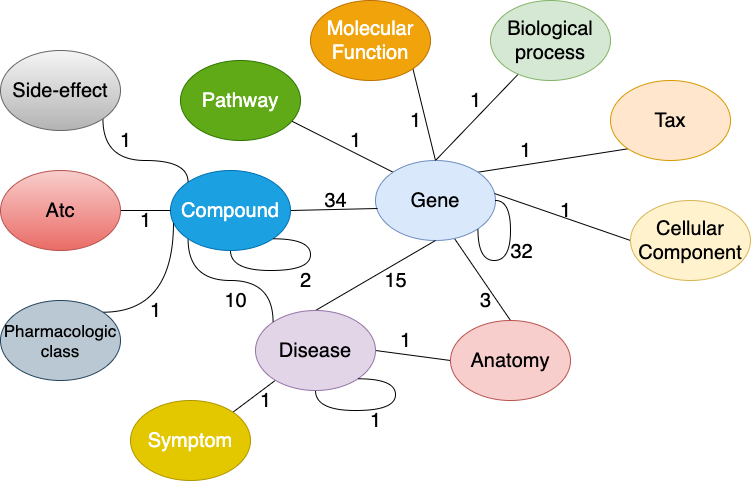

In [71]:
from IPython.display import Image
Image(filename='/home/jupyter/AIHub/COVID19/DRKG.png', width = 500, height = 300) 

It provide an example of using pretrained DRKG model for drug repurposing for COVID-19. In the example, we directly use the pretrained model provided at DRKG dataset and proposed 100 drugs for COVID-19. The following notebook provides the details:

+ [COVID-19_drug_repurposing.ipynb](https://github.com/gnn4dr/DRKG/blob/master/drug_repurpose/COVID-19_drug_repurposing.ipynb)

In [ ]:
## New Development: Docking of compounds against the active site of the COVID19
There are important enzymes that catalyze the cleavage of specific peptide bonds in viral polyprotein precursors or in cellular proteins. As such, inhibiting them is often a desired approach for inhibiting viral activity. Example can be COVID19 protease structure was recently published (PDB:6LU7).

This is an exploratory analysis aimed at identifying existing compounds that would serve as potential inhibitors of the SARS-CoV-2 protease: https://github.com/omarwagih/covid19-docking 
Several thousand compounds are docked on top the active site of the protease and the affinity is assessed. The compounds used range from ~700 Quercetin analogues (a known antiviral agent), ~5600 compounds in DrugBank, and ~500 antiviral compounds as determined by the ATC classification.


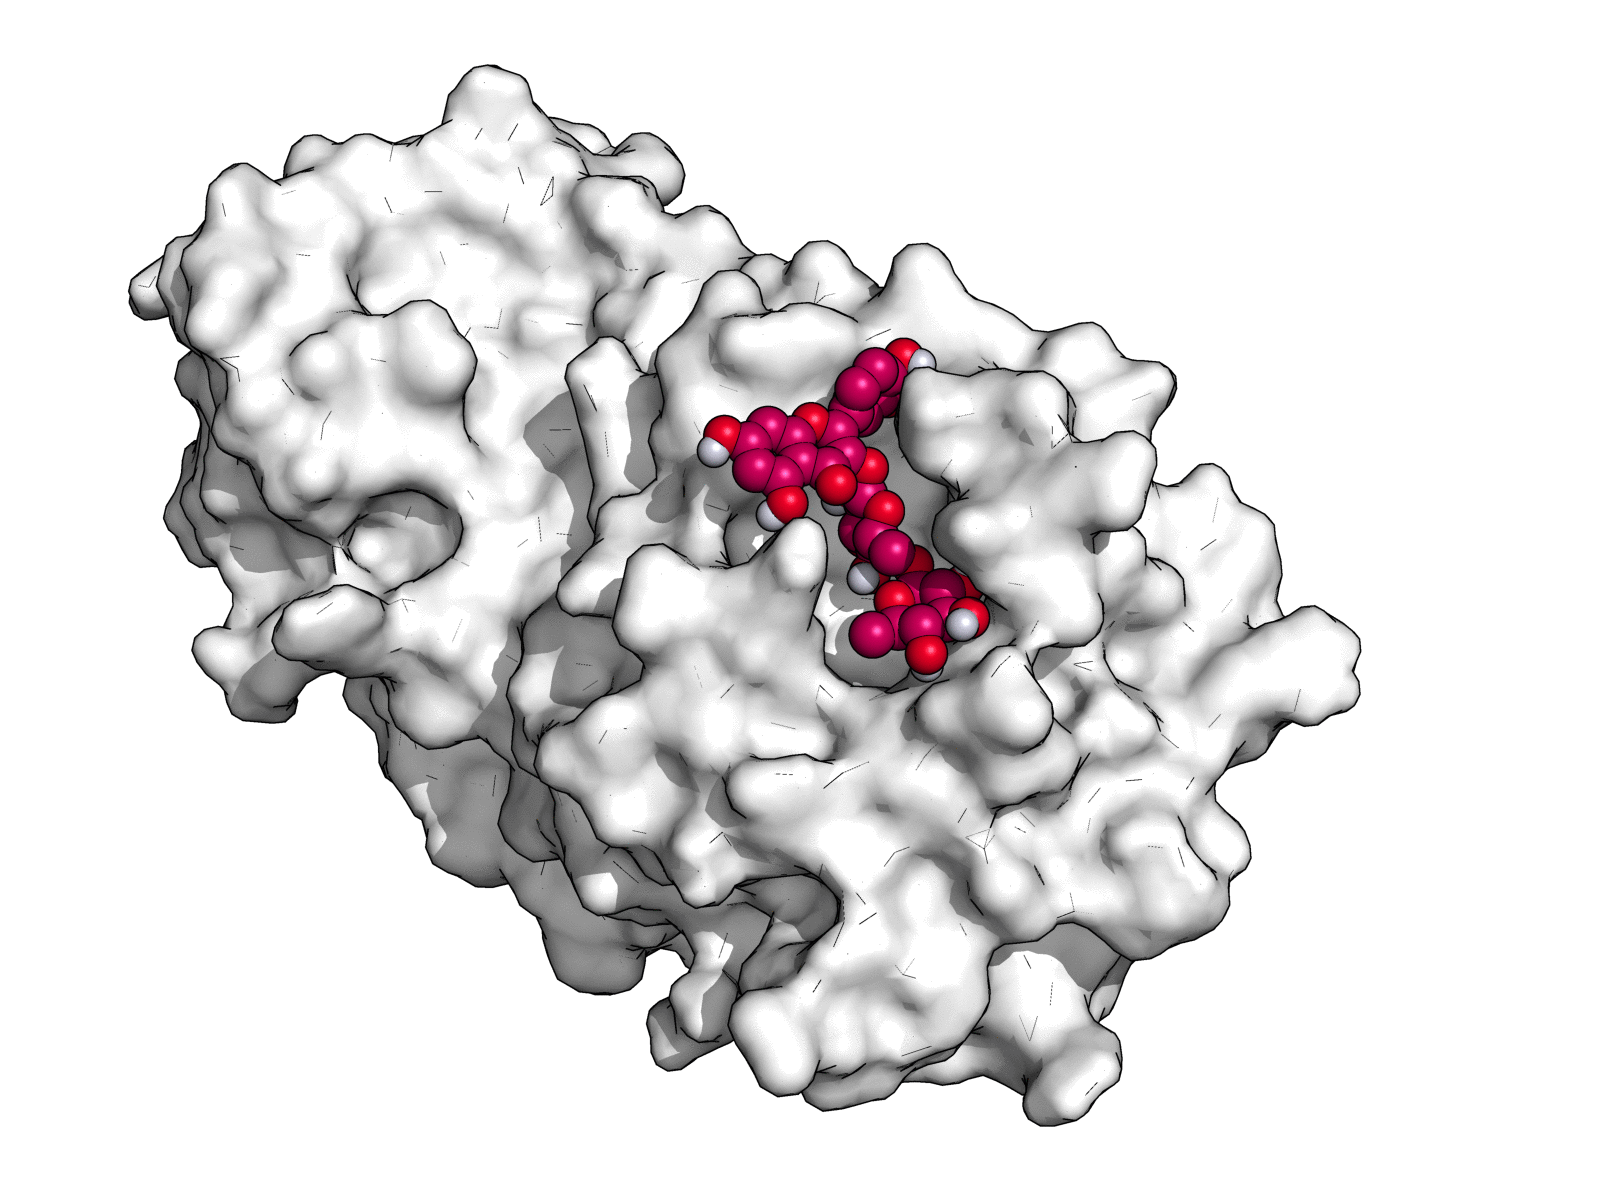

In [10]:
from IPython.display import Image
Image(filename='/home/jupyter/AIHub/COVID19/docking.gif', width = 500, height = 300) 